# Predict Price of Used Car Using Linear Regression
Predict the price of used car depending on its specifications

In [1]:
#import library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
sns.set()

In [2]:
#load raw data
raw_data = pd.read_csv(r'D:\Dokumen\PELATIHAN UDEMY\Data Analyst\The Data Science Course 2021 - All Resources\Part_5_Advanced_Statistical_Methods_(Machine_Learning)\S35_L225/1.04. Real-life example.csv')

In [3]:
raw_data.head(2)

,Brand,Price,Body,Mileage,EngineV,Engine Type,Registration,Year,Model
0,BMW,4200.0,sedan,277,2.0,Petrol,yes,1991,320
1,Mercedes-Benz,7900.0,van,427,2.9,Diesel,yes,1999,Sprinter 212


- Brand ==> BMW is generally more expensive than Toyota
- Mileage ==> the more car is driven, the cheaper it should be
- EngineV ==> sports car have larger engines than economy cars
- Year of production ==> the older the car, the cheaper it is, with exception of vintage vehicles

## Preprocessing

In [4]:
#descriptive statistics using describe()
#by default, only numerical values are shown
#(include = 'all') for numerical & categorical values
raw_data.describe(include= 'all')

#there are null values, because categorical doesn't have same types of numerical, and vice versa

,Brand,Price,Body,Mileage,EngineV,Engine Type,Registration,Year,Model
count,4345,4173.000000,4345,4345.000000,4195.000000,4345,4345,4345.000000,4345
unique,7,NaN,6,NaN,NaN,4,2,NaN,312
top,Volkswagen,NaN,sedan,NaN,NaN,Diesel,yes,NaN,E-Class
freq,936,NaN,1649,NaN,NaN,2019,3947,NaN,199
mean,NaN,19418.746935,NaN,161.237284,2.790734,NaN,NaN,2006.550058,NaN
std,NaN,25584.242620,NaN,105.705797,5.066437,NaN,NaN,6.719097,NaN
min,NaN,600.000000,NaN,0.000000,0.600000,NaN,NaN,1969.000000,NaN
25%,NaN,6999.000000,NaN,86.000000,1.800000,NaN,NaN,2003.000000,NaN
50%,NaN,11500.000000,NaN,155.000000,2.200000,NaN,NaN,2008.000000,NaN
75%,NaN,21700.000000,NaN,230.000000,3.000000,NaN,NaN,2012.000000,NaN


- There are missing values
- there are 312 unique values on 'Model' ==> really hard to implement at regression, that mean there are 312 dummies
- there are 3947 'yes' entries at Registration, almost all of them, looks like this variable won't be useful

In [5]:
#drop 'Model' feature
#axis 0 = row
#axis 1 = column
data = raw_data.drop(['Model'], axis=1)

### Dealing with missing values

In [6]:
data.shape

(4345, 8)

In [7]:
data.isnull().sum()

Brand             0
Price           172
Body              0
Mileage           0
EngineV         150
Engine Type       0
Registration      0
Year              0
dtype: int64

In [8]:
sum_null = 172 + 150
percent_null = (sum_null/(data.shape[0]))*100
percent_null

7.410817031070195

In [9]:
#to simplify we drop all missing value
#As a general guideline, some practitioners might consider dropping rows with missing values 
#if the percentage of missing values per row is below 5-10%
data_no_mv = data.dropna(axis=0)

### Exploring the PDF's

#### Price

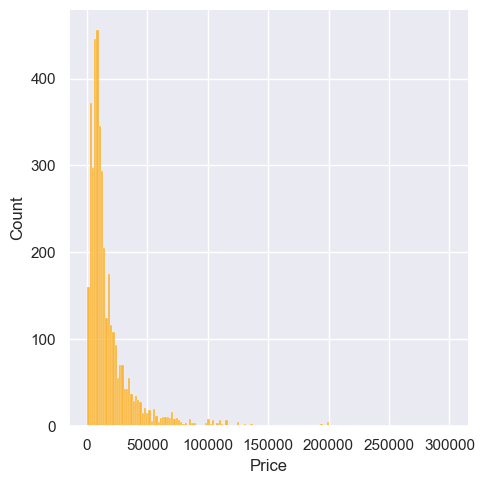

In [10]:
#PDF will show how how that variable is distributed
#and make it very easy to spot anomalies, such as outliers
#PDF is often the basis on which we decide whether we want to transform a feature
sns.displot(data_no_mv['Price'], color='orange')

#### Dealing with outlier's
- the outliers are situated around the higher prices (right side of the graph)
- From data.descibe(), price mean = 19,418, and q3 = 21,700, but max =300,000 !!!
- this is dataset about used car, therefore $300,000 is an excessive price
- Ouliers are great issue for OLS ==> **remove top 1% of distributions !!**

In [11]:
#99th percentile of 'Price' variable
q = data_no_mv['Price'].quantile(0.99)

#create new df with all prices < 99th percentile of 'Price'
data_1 = data_no_mv[data_no_mv['Price'] < q]

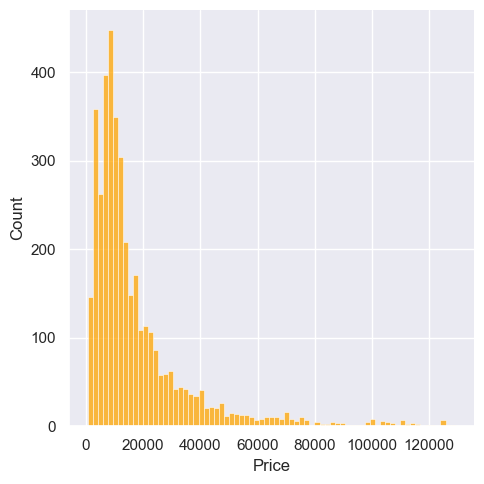

In [12]:
#check PDF once again to ensure the result is distributed in the same way
sns.displot(data_1['Price'], color='orange')

#there are much fewer outliers

#### Mileage

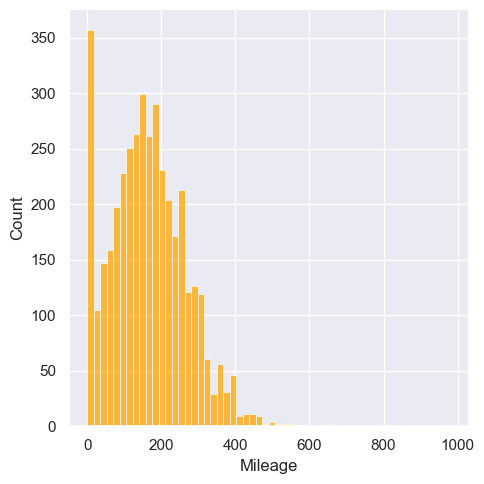

In [13]:
sns.displot(data_no_mv['Mileage'], color='orange')

In [14]:
#99th percentile of 'Mileage' variable
q = data_1['Mileage'].quantile(0.99)

#create new df with all prices < 99th percentile of 'Mileage'
data_2 = data_1[data_1['Mileage'] < q]

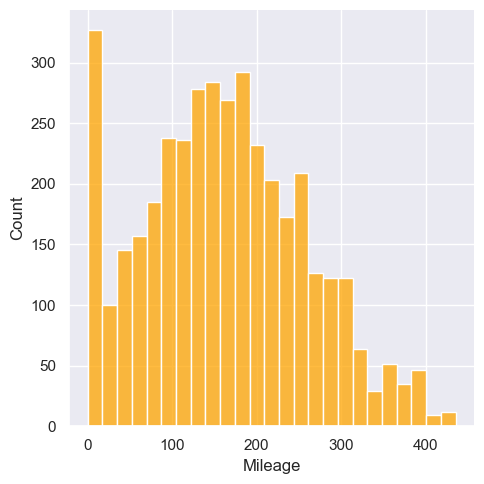

In [15]:
#check PDF once again to ensure the result is distributed in the same way
sns.displot(data_2 ['Mileage'], color='orange')

#the plot looks kinda normal

#### Engine Volume

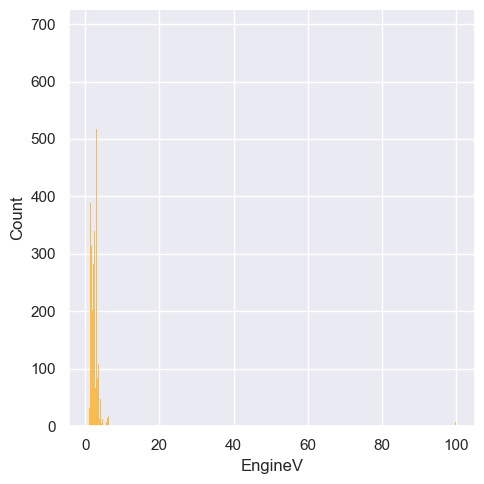

In [16]:
sns.displot(data_no_mv['EngineV'], color='orange')

- The situation with engine volume is very strange
- From google search, Car engine volumes are usually below 6.5l, so we're gonna select data below 6.5l

In [17]:
#select data engine below 6.5l
data_3 = data_2[data_2['EngineV'] < 6.5]

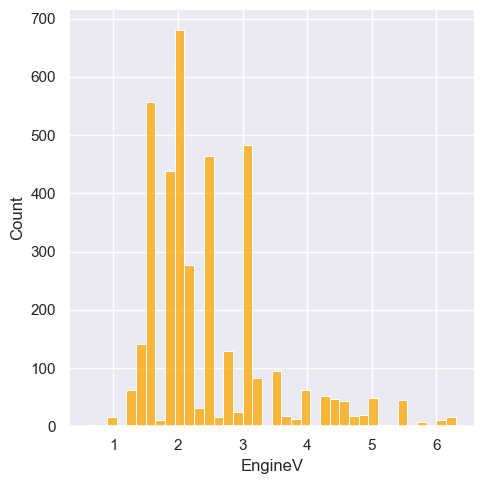

In [18]:
#check PDF once again to ensure the result is distributed in the same way
sns.displot(data_3 ['EngineV'], color='orange')

#### Year

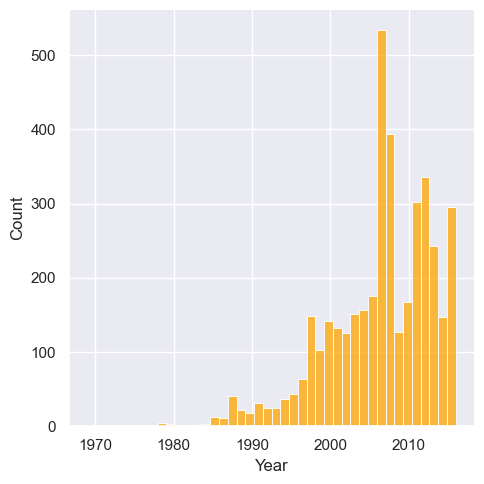

In [19]:
sns.displot(data_no_mv['Year'], color='orange')

In [20]:
#the outlier are on the low end
#simplify remove them (0.01)
q = data_3['Year'].quantile(0.01)

#select data > 0.01 year
data_4 = data_3[data_3['Year'] > q]

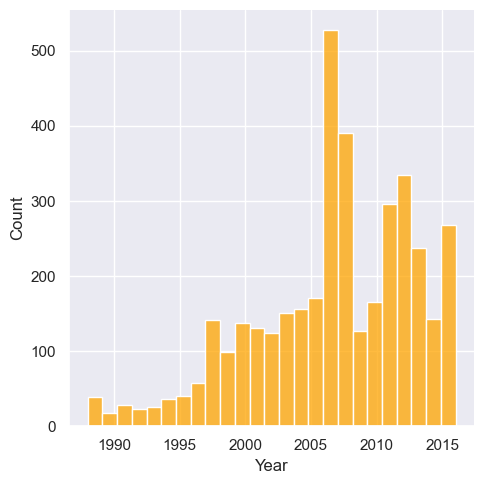

In [21]:
#check PDF once again to ensure the result is distributed in the same way
sns.displot(data_4['Year'], color='orange')

In [22]:
#reset index & drop old index
data_cleaned = data_4.reset_index(drop=True)

In [23]:
data_cleaned.describe(include='all')

,Brand,Price,Body,Mileage,EngineV,Engine Type,Registration,Year
count,3867,3867.000000,3867,3867.000000,3867.000000,3867,3867,3867.000000
unique,7,NaN,6,NaN,NaN,4,2,NaN
top,Volkswagen,NaN,sedan,NaN,NaN,Diesel,yes,NaN
freq,848,NaN,1467,NaN,NaN,1807,3505,NaN
mean,NaN,18194.455679,NaN,160.542539,2.450440,NaN,NaN,2006.709853
std,NaN,19085.855165,NaN,95.633291,0.949366,NaN,NaN,6.103870
min,NaN,800.000000,NaN,0.000000,0.600000,NaN,NaN,1988.000000
25%,NaN,7200.000000,NaN,91.000000,1.800000,NaN,NaN,2003.000000
50%,NaN,11700.000000,NaN,157.000000,2.200000,NaN,NaN,2008.000000
75%,NaN,21700.000000,NaN,225.000000,3.000000,NaN,NaN,2012.000000


## Checking the OLS assumptions
- OLS assumptions are fundamental to the linear regression model. 
- Checking these assumptions ensures that the model is valid  
  
**OLS Assumption :**
- Linearity = The relationship between the independent variables and the dependent variable is assumed to be linear
- Independence = The residuals (the differences between the observed and predicted values) should be independent
- No Perfect Multicollinearity
    
Because categorical data will be converted into dummies, we don't need to checking assumptions

### Check linearity

In [24]:
data_cleaned.head(1)

,Brand,Price,Body,Mileage,EngineV,Engine Type,Registration,Year
0,BMW,4200.0,sedan,277,2.0,Petrol,yes,1991


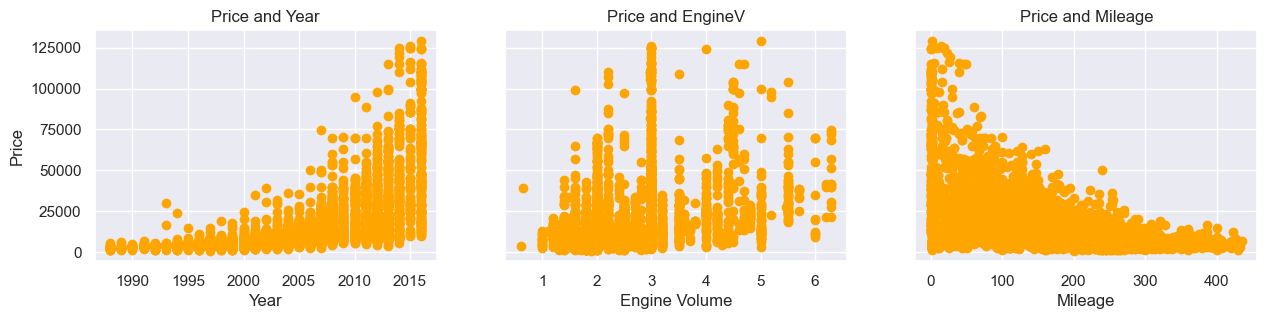

In [25]:
#since price is y axis of all the plots, plot them side by side (for comparison)
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(15,3)) #sharey -> share 'Price' as y

#scatter plot each year, engineV, and Mileage with price
ax1.scatter(data_cleaned['Year'], data_cleaned['Price'], color='orange')
ax1.set_title('Price and Year')
ax1.set_xlabel('Year')
ax1.set_ylabel('Price')

ax2.scatter(data_cleaned['EngineV'], data_cleaned['Price'], color='orange')
ax2.set_title('Price and EngineV')
ax2.set_xlabel('Engine Volume')

ax3.scatter(data_cleaned['Mileage'], data_cleaned['Price'], color='orange')
ax3.set_title('Price and Mileage')
ax3.set_xlabel('Mileage')

#show
plt.show()

- OLS assumption of linear regression is linear, but from the plot, price is **exponentially distributed**
- good transformation in that case is a **log transformation**

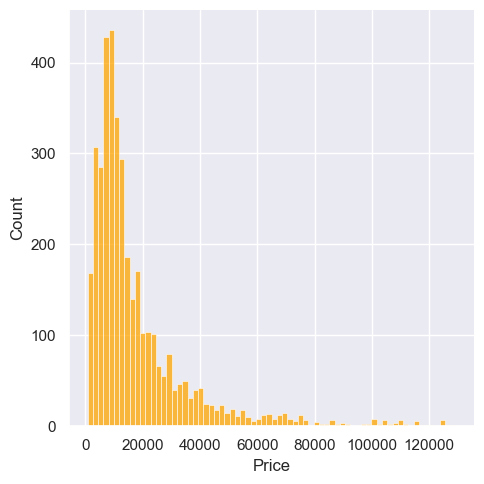

In [26]:
sns.displot(data_cleaned['Price'], color='orange')

- Price in not normally distributed, and not linear.
- The pattern are quite exponential ==> log transformation

#### Relaxing the assumptions

In [27]:
#transform price with log transformation
log_price = np.log(data_cleaned['Price'])

#add to df
data_cleaned['log_price'] = log_price

In [28]:
data_cleaned.head(1)

,Brand,Price,Body,Mileage,EngineV,Engine Type,Registration,Year,log_price
0,BMW,4200.0,sedan,277,2.0,Petrol,yes,1991,8.34284


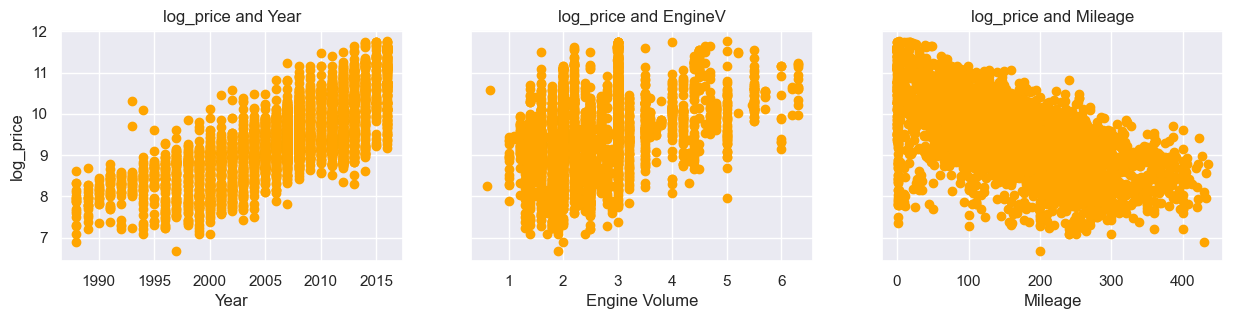

In [29]:
#check 3 scatters once again but with log_price
#since price is y axis of all the plots, plot them side by side (for comparison)
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(15,3)) #sharey -> share 'log_price' as y

#scatter plot each year, engineV, and Mileage with log_price
ax1.scatter(data_cleaned['Year'], data_cleaned['log_price'], color='orange')
ax1.set_title('log_price and Year')
ax1.set_xlabel('Year')
ax1.set_ylabel('log_price')

ax2.scatter(data_cleaned['EngineV'], data_cleaned['log_price'], color='orange')
ax2.set_title('log_price and EngineV')
ax2.set_xlabel('Engine Volume')

ax3.scatter(data_cleaned['Mileage'], data_cleaned['log_price'], color='orange')
ax3.set_title('log_price and Mileage')
ax3.set_xlabel('Mileage')

#show
plt.show()

- There are linear pattern in all plots now
- The lines fit the data so much better

In [30]:
#since we're using log_price, so we drop old 'Price'
data_cleaned = data_cleaned.drop(['Price'], axis=1)

In [31]:
data_cleaned.head(1)

,Brand,Body,Mileage,EngineV,Engine Type,Registration,Year,log_price
0,BMW,sedan,277,2.0,Petrol,yes,1991,8.34284


### Multicollinearity
- **Multicollinearity** is indicated by a high correlation between two or more independent variables
- Multicollinearity tends to inflate the standard errors of the regression coefficients, making them less precise.
- **The variance_inflation_factor (VIF)** is a measure used to detect multicollinearity in a regression model. 
- VIF quantifies how much the variance of the estimated regression coefficients is increased due to multicollinearity.
- **The higher the VIF, the more severe the multicollinearity**

VIF = 1 ==> no multicollinearity  
1 < VIF < 5 ==> perfectly okay  
10 < VIF ==> unacceptable

In [32]:
#columns of df
data_cleaned.columns.values

array(['Brand', 'Body', 'Mileage', 'EngineV', 'Engine Type',
       'Registration', 'Year', 'log_price'], dtype=object)

In [33]:
#check for multicollinearity with variance_inflation_factor
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [34]:
#since categorical data is not yet pre-processed, we'll take numerical ones
#it's logical that 'Year' & 'Mileage' will be correlated
variables = data_cleaned[['Mileage','Year','EngineV']]

In [35]:
variables.head(1)

,Mileage,Year,EngineV
0,277,1991,2.0


In [36]:
variables.shape

(3867, 3)

In [37]:
variables.shape[1]

3

In [38]:
range(variables.shape[1])

range(0, 3)

In [39]:
#new df that include all the VIFs
vif = pd.DataFrame()

#variance_inflation_factor
vif['VIF'] = [variance_inflation_factor(variables.values, i) for i in range(variables.shape[1])]

#Features column
vif['Features'] = variables.columns

In [40]:
vif

,VIF,Features
0,3.791584,Mileage
1,10.354854,Year
2,7.662068,EngineV


- Year has the highest VIF, drop 'Year'
- VIF 'Year' = 10.35 > 10 ==> unacceptable

In [41]:
data_cleaned.head(1)

,Brand,Body,Mileage,EngineV,Engine Type,Registration,Year,log_price
0,BMW,sedan,277,2.0,Petrol,yes,1991,8.34284


In [42]:
#drop year
data_no_multicollinearity = data_cleaned.drop(['Year'], axis=1)

## Create dummy variables
- For the first feature, we'll not create dummy
- Example : for 1st brand (Audi), dummy will get 1 0 0 0 0 0 0
- If we include separate dummy variables for each category, we will introduce multicollinearity to the regression
- As the Audi dummy would be perfectly determined by the other variables
- So **If we have N categories for feature, we have to create N-1 dummies** ==> drop_first=True

In [43]:
data_no_multicollinearity.head(2)

,Brand,Body,Mileage,EngineV,Engine Type,Registration,log_price
0,BMW,sedan,277,2.0,Petrol,yes,8.342840
1,Mercedes-Benz,van,427,2.9,Diesel,yes,8.974618


In [44]:
#create dummy for categorical variables
#'drop_first=True' used to drop the first category for each categorical variable when creating dummy variables
data_with_dummies = pd.get_dummies(data_no_multicollinearity, drop_first=True)

In [45]:
data_with_dummies.head(2)

,Mileage,EngineV,log_price,Brand_BMW,Brand_Mercedes-Benz,Brand_Mitsubishi,Brand_Renault,Brand_Toyota,Brand_Volkswagen,Body_hatch,Body_other,Body_sedan,Body_vagon,Body_van,Engine Type_Gas,Engine Type_Other,Engine Type_Petrol,Registration_yes
0,277,2.0,8.342840,1,0,0,0,0,0,0,0,1,0,0,0,0,1,1
1,427,2.9,8.974618,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1


### Rearrange order to get more organized
- Conventionally, the most intuitive order is: dependent variable, indepedendent numerical variables, dummies

In [46]:
#show the columns
data_with_dummies.columns.values

array(['Mileage', 'EngineV', 'log_price', 'Brand_BMW',
       'Brand_Mercedes-Benz', 'Brand_Mitsubishi', 'Brand_Renault',
       'Brand_Toyota', 'Brand_Volkswagen', 'Body_hatch', 'Body_other',
       'Body_sedan', 'Body_vagon', 'Body_van', 'Engine Type_Gas',
       'Engine Type_Other', 'Engine Type_Petrol', 'Registration_yes'],
      dtype=object)

In [47]:
#Rearrange order to get more organized
cols = ['log_price', 'Mileage', 'EngineV','Brand_BMW',
       'Brand_Mercedes-Benz', 'Brand_Mitsubishi', 'Brand_Renault',
       'Brand_Toyota', 'Brand_Volkswagen', 'Body_hatch', 'Body_other',
       'Body_sedan', 'Body_vagon', 'Body_van', 'Engine Type_Gas',
       'Engine Type_Other', 'Engine Type_Petrol', 'Registration_yes']

In [48]:
#implement reordering with create new df
data_preprocessed = data_with_dummies[cols]
data_preprocessed.head(2)

,log_price,Mileage,EngineV,Brand_BMW,Brand_Mercedes-Benz,Brand_Mitsubishi,Brand_Renault,Brand_Toyota,Brand_Volkswagen,Body_hatch,Body_other,Body_sedan,Body_vagon,Body_van,Engine Type_Gas,Engine Type_Other,Engine Type_Petrol,Registration_yes
0,8.342840,277,2.0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,1
1,8.974618,427,2.9,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1


### Calculate the Variance Inflation Factors (VIF)

In [49]:
#variables of data_preprocessed
variables = data_preprocessed

#create df
vif = pd.DataFrame()

#Calculate VIF
vif['VIF'] = [variance_inflation_factor(variables.values, i) for i in range(variables.shape[1])]

#add features column
vif['features'] = variables.columns

In [50]:
vif

,VIF,features
0,41.981260,log_price
1,4.460434,Mileage
2,13.445639,EngineV
3,2.603990,Brand_BMW
4,3.084356,Brand_Mercedes-Benz
5,1.830297,Brand_Mitsubishi
6,2.281498,Brand_Renault
7,2.406546,Brand_Toyota
8,3.312814,Brand_Volkswagen
9,1.583516,Body_hatch


- "log_price" has very high VIF. It implies that it is most definitely linearly correlated with all the other variables.
- Because We're using a linear regression to determine 'log_price' given values of the independent variables

## Linear Regression Model

### Declare the input and target

In [51]:
#targets (dependent variable) is 'log price'
targets = data_preprocessed['log_price']

#inputs are everything EXCEPT the dependent variable
inputs = data_preprocessed.drop(['log_price'], axis=1)

### Scale the data

In [52]:
#import scalling module
from sklearn.preprocessing import StandardScaler

In [53]:
#create scaler object
scaler = StandardScaler()

#fit the inputs
scaler.fit(inputs)

StandardScaler()

In [54]:
#scale the features
inputs_scaled = scaler.transform(inputs)

### Train Test Split

In [55]:
#import module for the split
from sklearn.model_selection import train_test_split

In [56]:
#80-20 split
x_train, x_test, y_train, y_test = train_test_split(inputs_scaled, targets, test_size= 0.2, random_state = 365)

### Create the regression

In [57]:
#create linear regression object
reg = LinearRegression()

#fit the regression with scaled train inputs & target
reg.fit(x_train, y_train)

LinearRegression()

In [58]:
#check the output of the regression
y_hat = reg.predict(x_train)

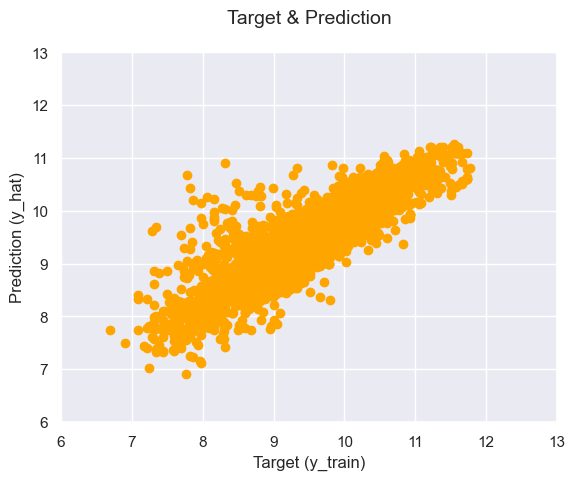

In [59]:
#the simplest way to compare the targets (y_train) & the predictions (y_hat) is to plot on scatter plot
#the closer the points to the 45-degree line, the better the prediction
plt.scatter(y_train, y_hat, color='orange')

#axes label
plt.xlabel('Target (y_train)', size=12)
plt.ylabel('Prediction (y_hat)', size=12)

#to prevent different scales of the x-axis and the y-axis
plt.xlim(6, 13)
plt.ylim(6, 13)

#title
plt.title('Target & Prediction\n', size=14)

plt.show()

### Checking Residuals

Text(0.5, 1.0, 'Residuals PDF\n')

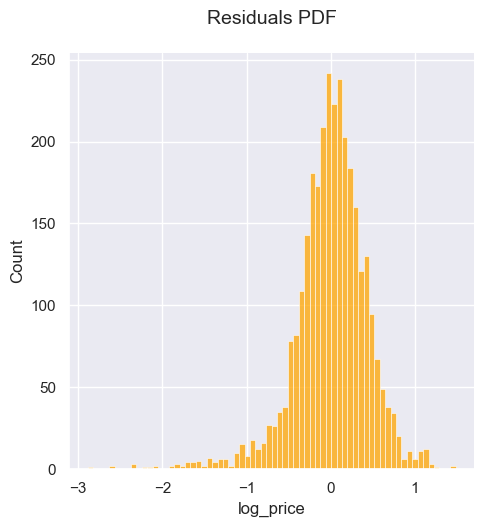

In [60]:
#Residual plots are essential for checking the assumptions and performance of a regression model
#plot the PDF of the residuals and check for anomalies
sns.displot(y_train - y_hat, color='orange')

#title
plt.title('Residuals PDF\n', size = 14)

- Residual plots help us assess the assumptions of linear regression. 
- The key assumptions include linearity, homoscedasticity (constant variance of residuals), independence of residuals, and normality of residuals
- A well-behaved residual plot indicates that our model satisfies these assumptions
- In the best case scenario this plot should be normally distributed
- But in our plot there are many negative residuals (far away from the mean)
- Negative values imply that y_hat (predictions) are much higher than y_train (the targets)
- If the predicted values are consistently much higher than the actual target values, it indicates that our model is likely overestimating the target variable, The model may have a bias issue, meaning it is not accurately capturing the underlying patterns in the data
- In summary, a consistent overestimation of predictions compared to actual values indicates a potential issue with our model that requires investigation and improvement

In [61]:
#R-squared of the model
reg.score(x_train, y_train)

0.744996578792662

- Our model is explaining 75% of the variablity of the data, relatively good result

### Finding the weight & bias

In [62]:
#bias or intercept of regression
reg.intercept_

9.415239458021299

In [63]:
#weights (coefficients) of the regression
reg.coef_

array([-0.44871341,  0.20903483,  0.0142496 ,  0.01288174, -0.14055166,
       -0.17990912, -0.06054988, -0.08992433, -0.1454692 , -0.10144383,
       -0.20062984, -0.12988747, -0.16859669, -0.12149035, -0.03336798,
       -0.14690868,  0.32047333])

In [64]:
#regression summary
reg_summary = pd.DataFrame(inputs.columns.values, columns=['Features'])

#add weight column
reg_summary['Weights'] = reg.coef_

In [65]:
reg_summary

,Features,Weights
0,Mileage,-0.448713
1,EngineV,0.209035
2,Brand_BMW,0.014250
3,Brand_Mercedes-Benz,0.012882
4,Brand_Mitsubishi,-0.140552
5,Brand_Renault,-0.179909
6,Brand_Toyota,-0.060550
7,Brand_Volkswagen,-0.089924
8,Body_hatch,-0.145469
9,Body_other,-0.101444


**Weights Interpretation**   
**Continues Variable :** 
- A positive weight shows that as a feature increases in value, so do log_price and 'Price' respectively
- Example : EngineV, the bigger the Engine volume, the higher the price
- A negative weight shows that as a feature increases in value, log_price and 'Price' decrease
- Example : Mileage, the more a car is being driven, the lower the price gets  

**Dummy Variable :** 
- It doesnt make sense to compare continues variable with the dummies 
- Dummies are compared with the benchamrk dummy
- A positive weight shows that the respective category is more expensive than the benchmark
- Example : respective category (BMV) is more expensive than the benchmark (Audi)
- A negative weight shows that the respective category is less expensive than the benchmark
- Example : respective category (Mitsubishi) is more expensive than the benchmark (Audi)  

  
The bigger the weights the bigger the impact  
Mileage is te most prominent feature in the regression. It is more than twice as important as Engine Volume

In [66]:
#check the different categories in the 'Brand' variable
#we can see which 'Brand' is actually the benchmark
data_cleaned['Brand'].unique()

array(['BMW', 'Mercedes-Benz', 'Audi', 'Toyota', 'Renault', 'Volkswagen',
       'Mitsubishi'], dtype=object)

- There were 7 brands, but by looking at the Weights table, we realized that Audi was the dropped one.
- Therefore whenever all dummies are 0, Audi is 1, so Audi is the benchmark

## Testing

In [67]:
#once we've trained and tuned our model, we can proceed to testing it
#test inputs = 'x_test', while the outputs = 'y_test'
#if the predictions are far off, then our model overfitted
#before we're already reset_index on data_cleaned = data_4.reset_index(drop=True)
#so we must reset the index and drop the old indexing on y_test too
y_test = y_test.reset_index(drop=True)

In [68]:
y_test.head(2)

0    7.740664
1    7.937375
Name: log_price, dtype: float64

In [69]:
#test prediction
y_hat_test = reg.predict(x_test)

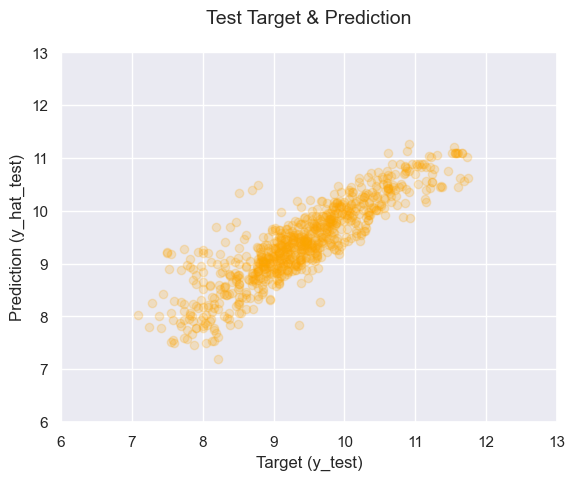

In [70]:
#scatter plot with test targets & test predictions
#set alpha to show the proportional opacity of the points
#the more saturated the color, the higher the concentration of points
#the paler the color, the lower the concentration of points
plt.scatter(y_test, y_hat_test, alpha=0.2, color='orange')

#label
plt.xlabel('Target (y_test)', size=12)
plt.ylabel('Prediction (y_hat_test)', size=12)

#title
plt.title('Test Target & Prediction\n', size=14)

#set xlim, ylim
plt.xlim(6,13)
plt.ylim(6,13)

plt.show()

- For high prices, we have a higher concentration of values around the 45 degree line ==> Our model is very good at predicting higher prices.
- Fow low price, they much more scattered ==> Our model is not quite getting the price right
- Our plot have much clearer indication, showing most of the points are indeed very close to the 45 degree line

In [71]:
#manually check on prediction
#normally we'd prefer prices, not their logarithms
#since log is the opposite of the exponential,
#if we take the exponential of the log_price, we'll reach their original prices
#create dataframe_prediction
df_pf = pd.DataFrame(data=(np.exp(y_hat_test)).round(2), columns=['Prediction'])

In [72]:
df_pf.head(2)

,Prediction
0,10685.50
1,3499.26


In [73]:
#add test target to compare
df_pf['Target'] = np.exp(y_test)

In [74]:
df_pf.head(2)

,Prediction,Target
0,10685.50,2300.0
1,3499.26,2800.0


In [75]:
#calculate residuals = the difference between the targets and the predictions
#Since OLS is basically an algorithm which minimizes the total sum of squared errors (residuals)
#this comparison makes a lot of sense
df_pf['Residual'] = df_pf['Target'] - df_pf['Prediction']

In [76]:
df_pf.head(2)

,Prediction,Target,Residual
0,10685.50,2300.0,-8385.50
1,3499.26,2800.0,-699.26


In [77]:
#add percentage on the difference
#we set np.absolute because whether an observation is off by +1% or -1% is mostly irrelevant
df_pf['Difference%'] = np.absolute(df_pf['Residual'] / df_pf['Target'] * 100)

In [78]:
df_pf.head(2)

,Prediction,Target,Residual,Difference%
0,10685.50,2300.0,-8385.50,364.586957
1,3499.26,2800.0,-699.26,24.973571


In [80]:
df_pf.describe()

,Prediction,Target,Residual,Difference%
count,774.00,774.00,774.00,774.00
mean,15946.76,18165.82,2219.06,36.26
std,13133.20,19967.86,10871.22,55.07
min,1320.56,1200.00,-29456.50,0.06
25%,7413.64,6900.00,-2044.19,12.11
50%,11568.17,11600.00,142.52,23.47
75%,20162.41,20500.00,3147.34,39.56
max,77403.06,126000.00,85106.16,512.69


- The minimum Difference% is 0.06%, the output was spot on
- The maximum Difference% is 512.69%, pretty off mark
- For the percentiles (25%, 50%, 75%) tells that most of our predictions are relatively close

In [79]:
#see all rows
pd.options.display.max_rows = 999

#set 2 digit after comma
pd.set_option('display.float_format', lambda x: '%.2f' % x)

#sort by difference in % 
df_pf.sort_values(by=['Difference%'])

,Prediction,Target,Residual,Difference%
698,30480.85,30500.00,19.15,0.06
742,16960.31,16999.00,38.69,0.23
60,12469.21,12500.00,30.79,0.25
110,25614.14,25500.00,-114.14,0.45
367,42703.68,42500.00,-203.68,0.48
369,3084.69,3100.00,15.31,0.49
769,29651.73,29500.00,-151.73,0.51
272,9749.53,9800.00,50.47,0.52
714,23118.07,22999.00,-119.07,0.52
630,8734.58,8800.00,65.42,0.74


- if we look at the bottom row, the observed price (target) are extremely low
- our model is using mileage, engine volume, brand, registration, and body type to predict the price of used car
- on average, our model is pretty decent at predicting the price, but for these last samples though it isn't
- all residuals for these outliers are negative, yherefore their prediction are higher than the target
- maybe we're missing important factor which drives the price of used car lower
- it may be the model of the car which we removed  
  
How to improve our model:
- use different set of variables
- remove bigger part of the outliers
- use different kinds of transformation